# Image rectification notebook
This notebook will showcase a method to rectify images such that scale can be obtained for ice objects on the sea plane.

#### Import all libraries we will need

In [298]:
# Importing libraries
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R

#### Import image with chessboard pattern and define pixel and world coordinates for corners

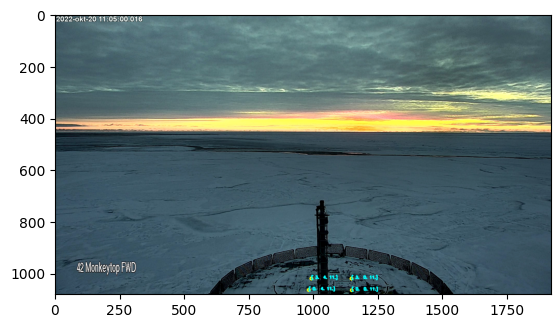

In [283]:
# Read image

im = cv.cvtColor(cv.imread("nabil_img.png"), cv.COLOR_BGR2RGB)
uv_chessboard = np.array([
    (1146, 1065), 
    (980, 1064),
    (990, 1020),
    (1145, 1020)
], dtype='int')

# Define world coordinates of these corners

h = 11# Height of chessboard w.r.t. water plane
w, l = 4, 3 # Width and length of chessboard
X_chessboard = np.array([
    (0, 0, h),
    (0, w, h),
    (l, w, h),
    (l, 0, h)
], dtype='double')


"""
im = cv.cvtColor(cv.imread("rectification.png"), cv.COLOR_BGR2RGB)
uv_chessboard = np.array([
    (500, 570),
    (410, 550),
    (480, 470),
    (570, 480),
], dtype='int')


# Define world coordinates of these corners

h = 5.9 # Height of chessboard w.r.t. water plane
w, l = 1.4, 2.7 # Width and length of chessboard
X_chessboard = np.array([
    (0, 0, h),
    (0, w, h),
    (l, w, h),
    (l, 0, h)
], dtype='double')
"""


im_uv = im.copy()
for i, center in enumerate(uv_chessboard):
    cv.circle(im_uv, tuple(center), radius=5, color=(255, 255, 0), thickness=4)
    cv.putText(im_uv, f"{X_chessboard[i]}", tuple(center), fontFace=0, fontScale=0.5, color=(0, 255, 255), thickness=3)
    
plt.imshow(im_uv)
plt.show()

# 2. Use camera pose to project chessboard coordinates to sea-level
Use method proposed by Nabil, where the chessboard corners can be scaled by a factor s = H / (H-h) in order to find it's projected size on the sea plane. H corresponds to the height of the camera, and h is the height of the chessboard (w.r.t. to sea plane).

In [358]:
WrWP = X_chessboard.T

# h is already defined, H is found from camera pose WrCW
H = 25.6

# Multiply all points by H/(H-h)
s = H/(H-h)
X_projected = WrWP * s
X_projected[2] = 0

print(f"Corner points projected to the sea plane is:\n{X_projected}\n")

Corner points projected to the sea plane is:
[[0.         0.         5.26027397 5.26027397]
 [0.         7.01369863 7.01369863 0.        ]
 [0.         0.         0.         0.        ]]



# 3. Create rectification matrix between the image plane and sea-plane

Text(0.5, 1.0, 'Rectified image [cm] 150x200m window')

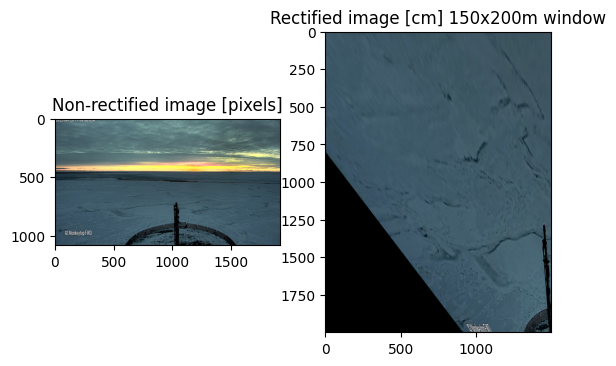

In [362]:
scale_factor = 10 #10 yields cm resolution
w, l = 150, 200 # Width and length of output (in meters)

# Scale up for higher resolution
X_perspective = X_projected_d.T[:, :2]
X_perspective = (X_perspective*scale_factor).astype(np.float32)
X_perspective[:, 1] += (w*scale_factor) / 2


# Compare image pixels (uv) with projected corner points (X_projected) to find rectification
M = cv.getPerspectiveTransform(uv_chessboard.astype(np.float32), X_perspective)

# Rectify image
im_rectified = cv.warpPerspective(im, M, (l*scale_factor, w*scale_factor))

# Create figure to compare rectification and original image
fig, ax = plt.subplots(1, 2)

ax[0].set_title("Non-rectified image [pixels]")
ax[0].imshow(im)

# Just a couple of image flips to visualize better
im_rectified = cv.transpose(im_rectified)
im_rectified = cv.flip(im_rectified, 0)
im_rectified = cv.flip(im_rectified, 1)
ax[1].imshow(im_rectified)
ax[1].set_title(f"Rectified image [cm] {w}x{l}m window")